In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from contractions import CONTRACTION_MAP
from re import compile, IGNORECASE, DOTALL, sub, escape
from string import punctuation
import numpy as np
#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
from wordcloud import WordCloud, STOPWORDS

import pprint
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import naive_bayes
from sklearn.metrics import classification_report

import seaborn as sns
import time
import random
random.seed(2018)

In [2]:
def tokenize_text(text):
    tokens = word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    return tokens

In [3]:
stopword_list = stopwords.words('english') # nltk.download()
wnl = WordNetLemmatizer()

In [4]:
def expand_contractions(text, contraction_mapping):
    contractions_pattern = compile('({})'.format('|'.join(contraction_mapping.keys())),flags=IGNORECASE | DOTALL)
    
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match) \
            if contraction_mapping.get(match) \
            else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = sub("'", "", expanded_text)
    return expanded_text

In [5]:
def remove_stopwords(text):
    words = tokenize_text(text)
    filtered_tokens = [word for word in words if word not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [6]:
def remove_special_characters(text):
    words = tokenize_text(text)
    pattern = compile('[{}]'.format(escape(punctuation)))
    filtered_words = filter(None, [pattern.sub('', word) for word in words])
    filtered_text = ' '.join(filtered_words)
    return filtered_text

In [7]:
def normalize_corpus(corpus, tokenize=False):
    normalized_corpus = []    
    for text in corpus:
        text = expand_contractions(text, CONTRACTION_MAP)
#        text = lemmatize_text(text)
        text = remove_special_characters(text)
        text = remove_stopwords(text)
        if tokenize:
            text = tokenize_text(text)
            normalized_corpus.append(text)
        else:
            normalized_corpus.append(text)
    return normalized_corpus

In [8]:
d1 = pd.read_csv("Medicare_National_HCPCS_Aggregate_Summary_Table_CY2015.csv")
d1 = d1[(d1.iloc[:,2] == 'N ')] # & (d1.iloc[:,3] == 'O ')
d1.head(2)

,HCPCS Code,HCPCS Description,HCPCS Drug Indicator,Place of Service,Number of Providers,Number of Services,Number of Unique Beneficiary/Provider Interactions,Number of Distinct Medicare Beneficiary/Per Day Services,Average Submitted Charge Amount,Average Medicare Allowed Amount,Average Medicare Payment Amount,Average Medicare Standardized Payment Amount
0,00100,Anesthesia for procedure on salivary gland wit...,N,F,9552,12180,12150,12174,1618.30,239.13,185.37,186.39
1,00100,Anesthesia for procedure on salivary gland wit...,N,O,10,12,12,12,850.24,207.42,162.61,167.26


In [9]:
d2 = d1.iloc[:,[1,3,8]]
d2.iloc[:,0] = d2.iloc[:,0].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
d2.iloc[:,0] = d2.iloc[:,0].apply(lambda x: re.sub('  ',' ', x))
d2.head(2)

C:\Users\sande\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,HCPCS Description,Place of Service,Average Submitted Charge Amount
0,anesthesia for procedure on salivary gland wit...,F,1618.30
1,anesthesia for procedure on salivary gland wit...,O,850.24


In [10]:
d2= d2.assign(PriceRange=np.nan)
d2.loc[d2.iloc[:,2]<d2.iloc[:,2].quantile(.2),'PriceRange'] = '1.veryLow'
d2.loc[(d2.iloc[:,2]<d2.iloc[:,2].quantile(.4))& (d2.iloc[:,2]>=d2.iloc[:,2].quantile(.2)),'PriceRange']='2.Low'
d2.loc[(d2.iloc[:,2]<d2.iloc[:,2].quantile(.6))& (d2.iloc[:,2]>=d2.iloc[:,2].quantile(.4)),'PriceRange']='3.Middle'
d2.loc[(d2.iloc[:,2]<d2.iloc[:,2].quantile(.8))& (d2.iloc[:,2]>=d2.iloc[:,2].quantile(.6)),'PriceRange']='4.High'
d2.loc[d2.iloc[:,2]>=d2.iloc[:,2].quantile(.8),'PriceRange']='5.veryHigh'
d2.head(2)

,HCPCS Description,Place of Service,Average Submitted Charge Amount,PriceRange
0,anesthesia for procedure on salivary gland wit...,F,1618.30,4.High
1,anesthesia for procedure on salivary gland wit...,O,850.24,3.Middle


In [11]:
d2['PriceRange']=d2['PriceRange'].astype('category')
Cat_type = CategoricalDtype(categories=list(['1.veryLow','2.Low','3.Middle','4.High','5.veryHigh']), ordered=True)
d2['PriceRange']=d2['PriceRange'].astype(Cat_type)

(array([1688.,  942.,  714.,  512.,  464.,  407.,  407.,  369.,  341.,
        313.,  286.,  243.,  276.,  237.,  243.,  219.,  234.,  210.,
        195.,  193.,  172.,  150.,  130.,  136.,  143.,  108.,  114.,
        112.,   80.,   89.]), array([  69.36      ,  194.43466667,  319.50933333,  444.584     ,
        569.65866667,  694.73333333,  819.808     ,  944.88266667,
       1069.95733333, 1195.032     , 1320.10666667, 1445.18133333,
       1570.256     , 1695.33066667, 1820.40533333, 1945.48      ,
       2070.55466667, 2195.62933333, 2320.704     , 2445.77866667,
       2570.85333333, 2695.928     , 2821.00266667, 2946.07733333,
       3071.152     , 3196.22666667, 3321.30133333, 3446.376     ,
       3571.45066667, 3696.52533333, 3821.6       ]), <a list of 30 Patch objects>)


C:\Users\sande\Anaconda3\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


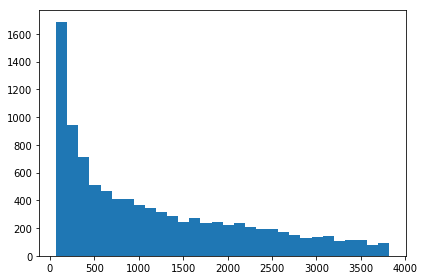

In [12]:
d2 = d2[(d2.iloc[:,2] < d2.iloc[:,2].quantile(.9))&(d2.iloc[:,2] > d2.iloc[:,2].quantile(.1))]
fig, axs = plt.subplots(1,1, sharey=True, tight_layout=True)
print(axs.hist(d2.iloc[:,2], bins=30))

(-0.5, 999.5, 499.5, -0.5)

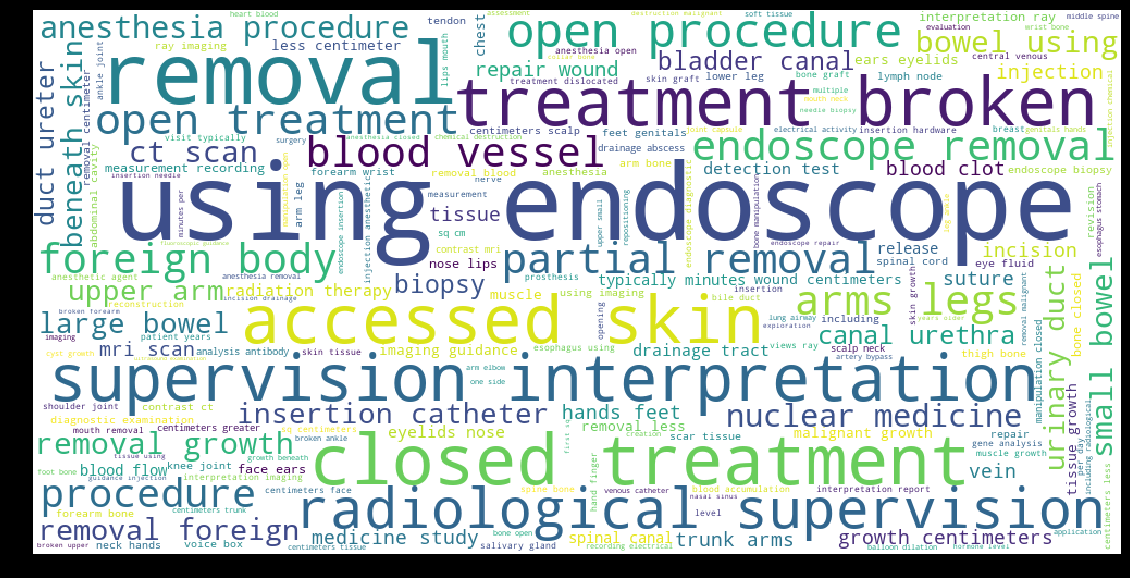

In [13]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color="white",stopwords=stopwords,
                      random_state = 2018,width=1000
                      , height=500).generate(" ".join([i for i in d2.iloc[:,0]]))
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")

In [14]:
train, validate = train_test_split(d2, test_size=.10, random_state=0)
train, validate = train.copy(), validate.copy()

In [15]:
train['ind'] = range(train.iloc[:,0].count())
train = train.set_index(['ind'])
train = pd.concat([train, pd.get_dummies(train['Place of Service'], drop_first= True)], axis = 1)
train = train.drop(['Place of Service'], axis = 1)

validate['ind'] = range(validate.iloc[:,0].count())
validate = validate.set_index(['ind'])
validate = pd.concat([validate, pd.get_dummies(validate['Place of Service'], drop_first= True)], axis = 1)
validate = validate.drop(['Place of Service'], axis = 1)

In [16]:
train.head(2)

,HCPCS Description,Average Submitted Charge Amount,PriceRange,O
ind,,,,
0,test for detecting genes associated with colon...,1922.42,4.High,1
1,exploration of kidney,2359.84,4.High,0


In [17]:
train_text_norm = normalize_corpus(train.iloc[:,0], tokenize=False)
train_target = train['Average Submitted Charge Amount']
train_target_cat = train['PriceRange']

validate_text_norm = normalize_corpus(validate.iloc[:,0], tokenize=False)
validate_target = validate['Average Submitted Charge Amount']
validate_target_cat = validate['PriceRange']

In [20]:
# Tuning parameters using a pipeline

pipeline = Pipeline([("vect", TfidfVectorizer(max_features=10000)),
                     ("model", RandomForestRegressor(random_state=0))])
parameters = {
    "vect__ngram_range": [(1, 1),(1, 2)],  
    "vect__max_df": [.99,0.90],
    "vect__min_df": [.01,0.1],
    "model__n_estimators": [60],
    "model__max_depth": [40]
}
grid = GridSearchCV(pipeline, parameters, cv=5, n_jobs=3)
start = time.time()
grid.fit(train_text_norm, train_target)
stop = time.time()
print("total time: ", stop-start)

total time:  99.76113557815552


In [60]:
# Analyze results
pprint.pprint(grid.best_params_)
# Generate predictions
model = grid.best_estimator_
predict = cross_val_predict(model, train_text_norm, train_target, cv=5, n_jobs=3)
predict_processed = [int(round(i)) for i in predict]
train_target_processed = [int(round(i)) for i in train_target]
# Analyze accuracy
print("Accuracy: %.3f" % (accuracy_score(train_target_processed, predict_processed)))
# Analyze Root Mean Squared Error
print("RMSE: %.2f "% np.sqrt(mean_squared_error(train_target, predict)))

{'model__max_depth': 40,
 'model__n_estimators': 60,
 'vect__max_df': 0.99,
 'vect__min_df': 0.01,
 'vect__ngram_range': (1, 1)}
Accuracy: 0.002
RMSE: 714.13 


In [22]:
Tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1),stop_words="english", max_df=.99, min_df=.01)
train_Tfidf_vectorized = Tfidf_vectorizer.fit_transform(train_text_norm)
train_Tfidf_vectorized_array = train_Tfidf_vectorized.toarray()
print("Here is the array shape \n", train_Tfidf_vectorized_array.shape, "\n")
features = Tfidf_vectorizer.get_feature_names()
#print("Here are the features extracted \n", features, "\n")
print("Here is what goes into the model \n", 
      pd.DataFrame(data=train_Tfidf_vectorized_array[0:2, :], columns=features).head(2), "\n")

Here is the array shape 
 (8754, 143) 

Here is what goes into the model 
    abdominal  abnormal  abscess  accessed  analysis  andor  anesthesia  ankle  \
0        0.0       0.0      0.0       0.0       0.0    0.0         0.0    0.0   
1        0.0       0.0      0.0       0.0       0.0    0.0         0.0    0.0   

   antibody  application  ...   upper  ureter  urethra  urinary  using  \
0       0.0          0.0  ...     0.0     0.0      0.0      0.0    0.0   
1       0.0          0.0  ...     0.0     0.0      0.0      0.0    0.0   

   vaginal  vein  wound  wrist  xray  
0      0.0   0.0    0.0    0.0   0.0  
1      0.0   0.0    0.0    0.0   0.0  

[2 rows x 143 columns] 



In [23]:
validate_Tfidf_vectorized = Tfidf_vectorizer.transform(validate_text_norm)
validate_Tfidf_vectorized_array = validate_Tfidf_vectorized.toarray()
print("Here is the array shape \n", validate_Tfidf_vectorized_array.shape, "\n")
features = Tfidf_vectorizer.get_feature_names()

Here is the array shape 
 (973, 143) 



In [24]:
train_Tfidf_vectorized_df = pd.DataFrame(data=train_Tfidf_vectorized_array, columns=features)
train_Tfidf_vectorized_df['Place_O'] = train.iloc[:,3]
validate_Tfidf_vectorized_df = pd.DataFrame(data=validate_Tfidf_vectorized_array, columns=features)
validate_Tfidf_vectorized_df['Place_O'] = validate.iloc[:,3]

In [25]:
#Support Vector Classification extended to solve regression problems
clf = svm.SVR()
clf.fit(train_Tfidf_vectorized_df, train_target)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [26]:
train_pre_clf = clf.predict(train_Tfidf_vectorized_df)
train_pre_clf_processed = [int(round(i)) for i in train_pre_clf]
train_target_processed = [int(round(i)) for i in train_target]
print("Train_svm - Accuracy: %.3f " % (accuracy_score(train_pre_clf_processed,train_target_processed)))
print("Train_svm - RMSE: $%.2f " % np.sqrt(mean_squared_error(train_pre_clf_processed,train_target_processed)))
validate_pre_clf = clf.predict(validate_Tfidf_vectorized_df)
validate_pre_clf_processed = [int(round(i)) for i in validate_pre_clf]
validate_target_processed = [int(round(i)) for i in validate_target]
print("Validate_svm - Accuracy: %.3f " % (accuracy_score(validate_pre_clf_processed,validate_target_processed)))
print("Validate_svm - RMSE: $%.2f " % np.sqrt(mean_squared_error(validate_pre_clf_processed,validate_target_processed)))

Train_svm - Accuracy: 0.000 
Train_svm - RMSE: $1056.51 
Validate_svm - Accuracy: 0.001 
Validate_svm - RMSE: $1060.16 


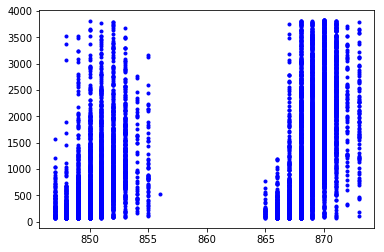

In [27]:
plt.plot(train_pre_clf_processed, train_target_processed, 'b.')

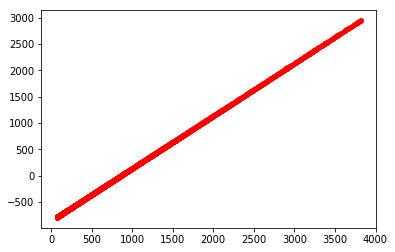

In [28]:
plt.plot(train_target,(train_target - train_pre_clf), 'r.')

In [29]:
# RandomForestRegressor 
# Cross-validate Predict 
model = RandomForestRegressor(n_estimators=60, max_depth=40)
predict = cross_val_predict(model, train_Tfidf_vectorized_df, train_target)
predict_processed = [int(round(i)) for i in predict]
# Analyze accuracy
print("Train_rfr - Accuracy: %.3f " % (accuracy_score(predict_processed,train_target_processed )))
# Analyze Root Mean Squared Error
print("Train_rfr - RMSE: $%.2f " % np.sqrt(mean_squared_error(predict, train_target)))

Train_rfr - Accuracy: 0.001 
Train_rfr - RMSE: $706.44 


In [30]:
predict2 = cross_val_predict(model, validate_Tfidf_vectorized_df, validate_target)
predict2_processed = [int(round(i)) for i in predict2]
# Analyze accuracy
print("Validate_rfr - Accuracy: %.3f " % (accuracy_score(predict2_processed, validate_target_processed ) ))
# Analyze Root Mean Squared Error
print("Validate_rfr - RMSE: $%.2f " % np.sqrt(mean_squared_error(predict2, validate_target)))

Validate_rfr - Accuracy: 0.002 
Validate_rfr - RMSE: $805.33 


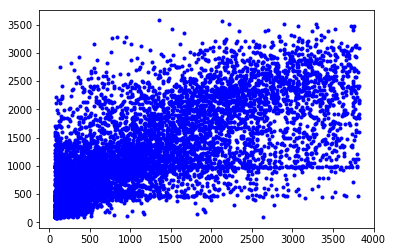

In [31]:
plt.plot(train_target, predict, 'b.')

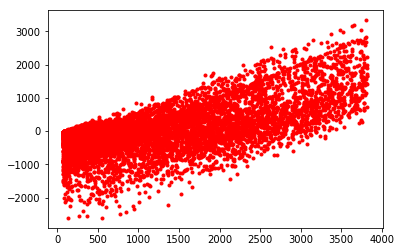

In [32]:
plt.plot(train_target,(train_target - predict), 'r.')

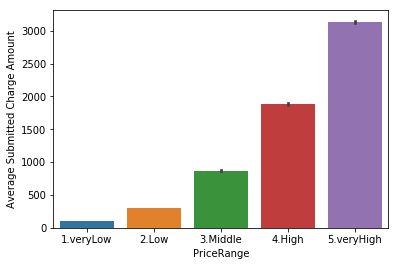

In [59]:
sns.barplot(x=d2['PriceRange'], y=d2['Average Submitted Charge Amount'])

In [33]:
# Logistic Regression Classification
clfrLR = LogisticRegression()
clfrLR.fit(train_Tfidf_vectorized_df, train_target_cat)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [34]:
train_predict_prices = clfrLR.predict(train_Tfidf_vectorized_df)
print("Logistic Regression - Training data")
print(classification_report(train_target_cat, train_predict_prices))
feature_names= np.array(features)
sored_coef_index = clfrLR.coef_[0].argsort()
print('Smallest Coefs:\n{}\n'.format(feature_names[sored_coef_index[:15]]))
print('Largest Coefs:\n{}\n'.format(feature_names[sored_coef_index[:-15:-1]]))

Logistic Regression - Training data
             precision    recall  f1-score   support

  1.veryLow       0.64      0.45      0.53      1094
      2.Low       0.51      0.63      0.57      2195
   3.Middle       0.50      0.46      0.48      2175
     4.High       0.49      0.61      0.54      2204
 5.veryHigh       0.58      0.29      0.39      1086

avg / total       0.53      0.52      0.51      8754

Smallest Coefs:
['endoscope' 'repair' 'insertion' 'removal' 'destruction' 'anesthesia'
 'joint' 'radiation' 'graft' 'closed' 'open' 'drainage' 'incision'
 'accessed' 'growth']

Largest Coefs:
['xray' 'antibody' 'level' 'physician' 'measurement' 'detection' 'test'
 'body' 'imaging' 'interpretation' 'growths' 'minutes' 'examination'
 'including']



In [35]:
validate_predict_prices = clfrLR.predict(validate_Tfidf_vectorized_df)
print("Logistic Regression - Validatiton data")
print(classification_report(validate_target_cat, validate_predict_prices))

Logistic Regression - Validatiton data
             precision    recall  f1-score   support

  1.veryLow       0.64      0.45      0.53       121
      2.Low       0.46      0.58      0.52       237
   3.Middle       0.51      0.42      0.46       257
     4.High       0.44      0.60      0.51       228
 5.veryHigh       0.54      0.28      0.37       130

avg / total       0.50      0.49      0.48       973



In [36]:
# Classification naive bayes classifier
clfrNB = naive_bayes.MultinomialNB()
clfrNB.fit(train_Tfidf_vectorized_df, train_target_cat)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [37]:
train_predict_prices = clfrNB.predict(train_Tfidf_vectorized_df)
print("Naive Bayes - Training data")
print(classification_report(train_target_cat, train_predict_prices))

Naive Bayes - Training data
             precision    recall  f1-score   support

  1.veryLow       0.60      0.44      0.51      1094
      2.Low       0.50      0.55      0.53      2195
   3.Middle       0.46      0.39      0.42      2175
     4.High       0.45      0.69      0.54      2204
 5.veryHigh       0.63      0.17      0.27      1086

avg / total       0.51      0.49      0.47      8754



In [38]:
validate_predict_prices = clfrNB.predict(validate_Tfidf_vectorized_df)
print("Naive Bayes - Validatiton data")
print(classification_report(validate_target_cat, validate_predict_prices))

Naive Bayes - Validatiton data
             precision    recall  f1-score   support

  1.veryLow       0.65      0.43      0.52       121
      2.Low       0.47      0.51      0.49       237
   3.Middle       0.48      0.38      0.42       257
     4.High       0.40      0.71      0.51       228
 5.veryHigh       0.54      0.12      0.19       130

avg / total       0.49      0.46      0.44       973



In [39]:
# Classification support vector machine
clfrSVM = svm.SVC(kernel = 'linear', C = 0.1) #suport vector classifier 
clfrSVM.fit(train_Tfidf_vectorized_df, train_target_cat)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [40]:
train_predict_prices = clfrSVM.predict(train_Tfidf_vectorized_df)
print("Support vector machine - Training data")
print(classification_report(train_target_cat, train_predict_prices))

sored_coef_index = clfrSVM.coef_[0].argsort()
print('Smallest Coefs:\n{}\n'.format(feature_names[sored_coef_index[:15]]))
print('Largest Coefs:\n{}\n'.format(feature_names[sored_coef_index[:-15:-1]]))

Support vector machine - Training data
             precision    recall  f1-score   support

  1.veryLow       0.69      0.37      0.48      1094
      2.Low       0.50      0.66      0.57      2195
   3.Middle       0.47      0.45      0.46      2175
     4.High       0.45      0.65      0.53      2204
 5.veryHigh       0.00      0.00      0.00      1086

avg / total       0.44      0.49      0.45      8754

Smallest Coefs:
['injection' 'recording' 'brain' 'muscles' 'contrast' 'needle' 'spinal'
 'canal' 'radiological' 'joint' 'insertion' 'destruction' 'supervision'
 'scan' 'biopsy']

Largest Coefs:
['antibody' 'level' 'test' 'xray' 'measurement' 'detection' 'physician'
 'bones' 'abnormal' 'spine' 'breast' 'elbow' 'wrist' 'small']



C:\Users\sande\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [41]:
validate_predict_prices = clfrSVM.predict(validate_Tfidf_vectorized_df)
print("Support vector machine - Validate data")
print(classification_report(validate_target_cat, validate_predict_prices))

Support vector machine - Validate data
             precision    recall  f1-score   support

  1.veryLow       0.67      0.31      0.43       121
      2.Low       0.45      0.62      0.52       237
   3.Middle       0.45      0.42      0.44       257
     4.High       0.42      0.65      0.51       228
 5.veryHigh       0.00      0.00      0.00       130

avg / total       0.41      0.45      0.41       973



C:\Users\sande\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
